In [57]:
from urllib.request import urlretrieve
url = "https://cc.tvbs.com.tw/img/upload/2019/09/05/20190905091801-2b51f0a7.jpg"
urlretrieve(url, "target.jpg")
styleurl = "http://decomyplace.com/img/blog/180809_ukiyo_0.jpg"
urlretrieve(styleurl, "style.jpg")

('style.jpg', <http.client.HTTPMessage at 0x7f457cf8b400>)

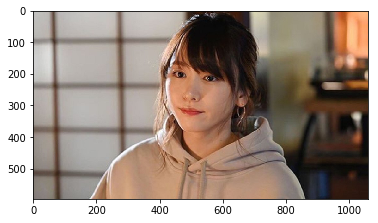

In [58]:
from keras.preprocessing.image import load_img, save_img, img_to_array
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(load_img("target.jpg"))

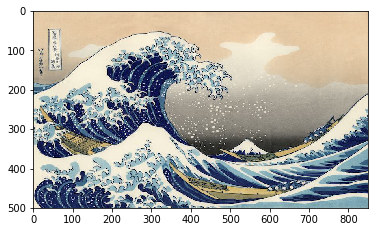

In [59]:
plt.imshow(load_img("style.jpg"))

In [60]:
from keras.applications import vgg19
import numpy as np
def preprocess(path, h, w):
    img = load_img(path, target_size=(h, w)).convert("RGB")
    img = img_to_array(img)
    img = vgg19.preprocess_input(img)
    img = np.expand_dims(img, axis=0)
    return img
preprocess("target.jpg", 400, 300).shape

(1, 400, 300, 3)

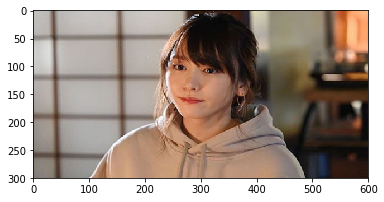

In [61]:
def deprocess(x, h, w):
    x = x.reshape(h, w, 3)
    x[:, :, 0] = x[:, :, 0] + 103.939
    x[:, :, 1] = x[:, :, 1] + 116.779
    x[:, :, 2] = x[:, :, 2] + 123.68
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype("uint8")
    return x
pre = preprocess("target.jpg", 300, 600)
de = deprocess(pre, 300, 600)
plt.imshow(de)

In [62]:
w, h = load_img("target.jpg").size
width = 400
height = int(width * h / w)
print(w, h)
print("新的width", width)
print("新的height", height)

1060 596
新的width 400
新的height 224


In [63]:
import keras.backend as K
base_img = K.variable(preprocess("target.jpg", height, width))
style_img = K.variable(preprocess("style.jpg", height, width))
combined_img = K.placeholder((1, height, width, 3))
input_tensor = K.concatenate([base_img, style_img, combined_img], axis=0)
model = vgg19.VGG19(input_tensor=input_tensor, include_top=False)
model.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

In [0]:
import tensorflow as tf
session = tf.Session()
def gram_matrix(x):
    m = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
    return K.dot(m, K.transpose(m))
    


In [0]:
def style_loss(style, combine, h, w, c=3):
    sgram = gram_matrix(style)
    cgram = gram_matrix(combine)
    size = w * h
    return K.sum(K.square(sgram - cgram)) / 4 / (c ** 2) / (size ** 2)

def content_loss(target, combine):
    return K.sum(K.square(target - combine))

def variation_loss(combine, h, w):
    a = K.square(combine[:, :h-1, :w-1, :] - combine[:, 1:, :w-1, :])
    b = K.square(combine[:, :h-1, :w-1, :] - combine[:, :h-1, 1:, :])
    return K.sum(K.pow(a + b, 1.25))

In [66]:
layer_dict = {l.name:l.output for l in model.layers}
layer_dict

{'block1_conv1': <tf.Tensor 'block1_conv1_3/Relu:0' shape=(3, 224, 400, 64) dtype=float32>,
 'block1_conv2': <tf.Tensor 'block1_conv2_3/Relu:0' shape=(3, 224, 400, 64) dtype=float32>,
 'block1_pool': <tf.Tensor 'block1_pool_3/MaxPool:0' shape=(3, 112, 200, 64) dtype=float32>,
 'block2_conv1': <tf.Tensor 'block2_conv1_3/Relu:0' shape=(3, 112, 200, 128) dtype=float32>,
 'block2_conv2': <tf.Tensor 'block2_conv2_3/Relu:0' shape=(3, 112, 200, 128) dtype=float32>,
 'block2_pool': <tf.Tensor 'block2_pool_3/MaxPool:0' shape=(3, 56, 100, 128) dtype=float32>,
 'block3_conv1': <tf.Tensor 'block3_conv1_3/Relu:0' shape=(3, 56, 100, 256) dtype=float32>,
 'block3_conv2': <tf.Tensor 'block3_conv2_3/Relu:0' shape=(3, 56, 100, 256) dtype=float32>,
 'block3_conv3': <tf.Tensor 'block3_conv3_3/Relu:0' shape=(3, 56, 100, 256) dtype=float32>,
 'block3_conv4': <tf.Tensor 'block3_conv4_3/Relu:0' shape=(3, 56, 100, 256) dtype=float32>,
 'block3_pool': <tf.Tensor 'block3_pool_3/MaxPool:0' shape=(3, 28, 50, 256) 

In [0]:
style = 1.0
variation = 1.0
content = 0.025

loss = K.variable(0.0)

# content loss
block5_outputs = layer_dict["block5_conv2"]
b = block5_outputs[0, :, :, :] 
c = block5_outputs[2, :, :, :]
loss = loss + content * content_loss(b, c)

# style loss
layers = ["block1_conv1", "block2_conv1",
          "block3_conv1", "block4_conv1", 
          "block5_conv1"]
for l in layers:
    output = layer_dict[l]
    ss = output[1, :, :, :]
    cs = output[2, :, :, :]
    sl = style_loss(ss, cs, height, width)
    loss = loss + style * sl / len(layers)
    
# variation loss
loss = loss + variation * variation_loss(combined_img, height, width)